In [47]:
%matplotlib inline
import os

import pandas as pd
import xarray as xr

import rtmtools.clirad.sw.wrangle as swwrangle
import rtmtools.lblrtm.visualisation as viz

In [6]:
def filepath():
    path_CLIRAD_OUTPUT_gpts = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_gpts/OUTPUT_CLIRAD_gpts.dat'
    return path_CLIRAD_OUTPUT_gpts

In [45]:
def plot_pressure_VS_dTdt_linearlog(ds, whichrate = 'heating_rate', ib = 7):
    
    Nik = 6
    
    srss = [ds[whichrate].sel(ib = ib, ik = ik).to_pandas() for ik in range(1, Nik + 1)]
    names = ['(ib, ik) = ({}, {})'.format(ib, ik) for ik in range(1, Nik + 1)]
        
    #colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs = Nik))
    colours, linestyles = zip(*viz.matplotlib_colour_linestyle_tuples(N = Nik))
    
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(whichrate)
    title = 'Band {}'.format(ib)
    figsize = (15, 10)
    
    fig = viz.plot_pdseries_indexVSvalues_linearlog(srss = srss,\
                                                names = names,
                                                colours = colours,
                                                linestyles = linestyles,
                                                ylabel = ylabel,
                                                xlabel = xlabel,
                                                figsize = figsize,
                                                title = title)
    return fig

In [22]:
ds = swwrangle.load_clirad_solirgpts(fpath=filepath(),
                                     signed_fluxes=True,
                                     cooling_rate=True)

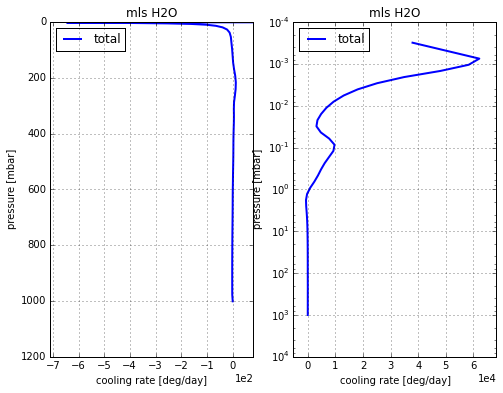

In [82]:
srs = ds['cooling_rate'].sum(dim=['ib', 'ik']).to_pandas()

names = ['total']
colours = ['b']
linestyles = ['-']
ylabel = 'pressure [mbar]'
xlabel = 'cooling rate [deg/day]'
figsize = (8, 6)
title = 'mls H2O'

fig = viz.plot_pdseries_indexVSvalues_linearlog(srss=[srs],
                                                names=names,
                                                colours=colours,
                                                linestyles=linestyles,
                                                ylabel=ylabel,
                                                xlabel=xlabel,
                                                figsize=figsize,
                                                title=title)

In [86]:
ds.sel(ib=9, ik=1)[['flux_up', 'flux_down']]

<xray.Dataset>
Dimensions:    (pressure: 76)
Coordinates:
  * pressure   (pressure) float64 0.0 0.0006244 0.0008759 0.001229 0.001723 ...
    ib         int64 9
    ik         int64 1
Data variables:
    flux_up    (pressure) float64 0.9585 0.9585 0.9585 0.9585 0.9585 0.9585 ...
    flux_down  (pressure) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [107]:
ds['cooling_rate'].to_dataframe().unstack(['ib', 'ik']).to_excel('mls_H2O_gpts.xlsx')